# $\textit{Análisis de respuestas impulsivas}$
$\textit{By Agustín Luís Gullino - Gonzalo Ezequiel Linares}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp
import helper as hp
import importlib
importlib.reload(hp)

fs = 48000  # Frecuencia de muestreo
f0 = 20     # Limite inferior de frecuencias en rango audible
f1 = 20000  # limite superior de frecuencias en rango audible

# $\textit{1)}$

Para la selección de la señal de música, realizamos una búsqueda entre distintos géneros musicales y observamos el espectrograma de varias canciones. Buscamos aquella canción que contenga dentro de los 10 segundos a utilizar, la mayor cantidad de frecuencias posibles. Finalmente, elegimos la canción "Fly me to the moon" de Frank Sinatra debido a que tiene un amplio contenido espectral.

Nuevamente, para la señal de voz, se utilizó el mismo criterio que para la selección de la señal de música.

In [2]:
origfs, origSignal, origpath = hp.getOriginalSignals()

In [ ]:
recfs, recSignal, recpath = hp.getRecordedSignals()

# $\textit{2)}$

Aclaración: Las señales grabadas se sincronizaron con las originales a través del uso de un impulso presente en el archivo reproducido que permitió alinearlas en un programa de edición de audio. Para asegurar causalidad, se dió un espacio de algunos milisegundos de adelanto para la señal original. También es importante mencionar que para la estimación de la PSD no se utilizó una ventana, ya que se está trabajando con señales limitadas en tiempo. Más adelante se presenta una justificación para esta decisión.

Observando los gráficos de las PSDs, intuimos que la señal que mejor va funcionar para obtener h(n) es el barrido lineal porque excita al sistema con un espectro de potencia más constante en escala logarítmica que los demás. También se puede apreciar que tanto el barrido lineal y el exponencial son aquellos que menos dispersión tienen.

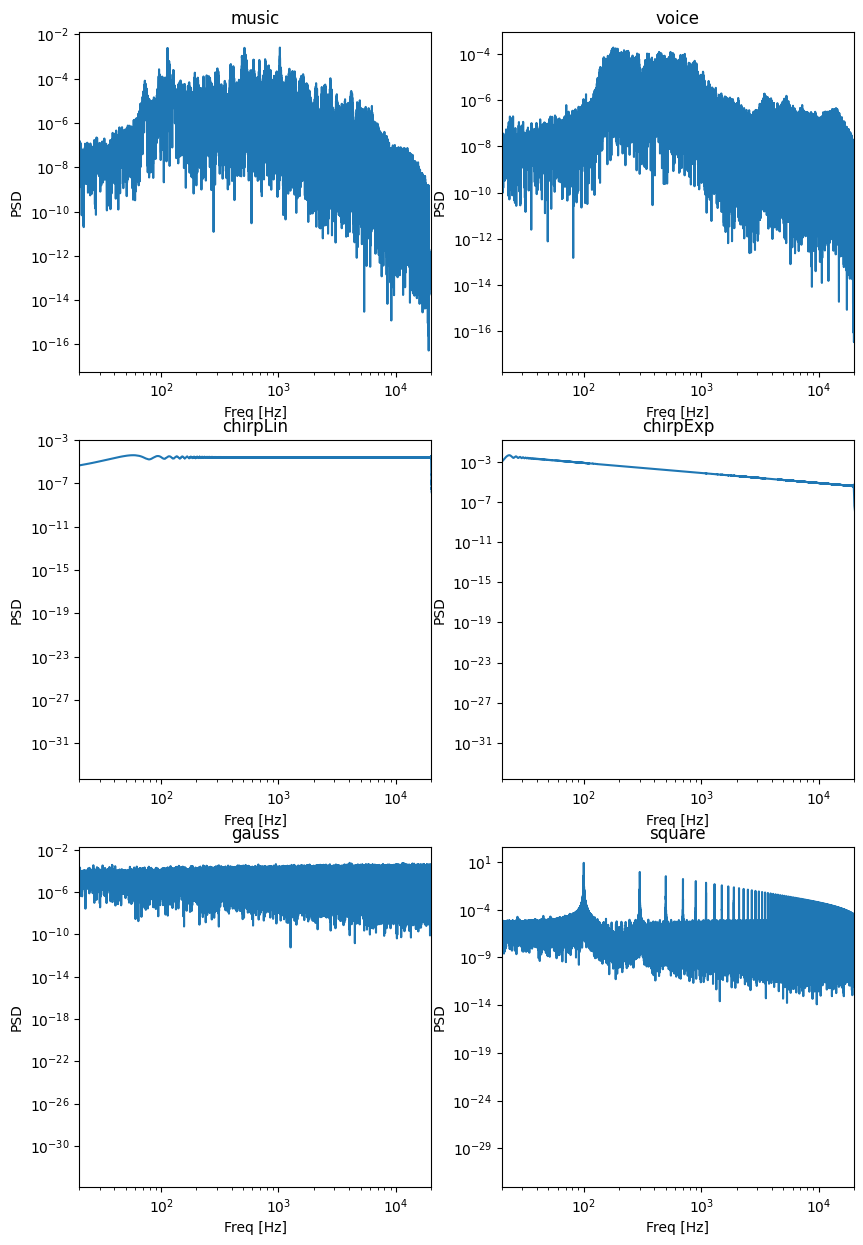

In [26]:
plt.figure(figsize=(10, 15))

for i, (name, s) in enumerate(zip(origSignal.keys(), origSignal.values())):
    f, Pxx_den = sp.periodogram(s, fs=fs, window='boxcar', nfft=hp.getNextPowerOfTwo(len(s)*5))
    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('Freq [Hz]')
    plt.ylabel('PSD')
    plt.xlim((f0, f1))
    plt.loglog(f, Pxx_den)

$\textit{Coeficientes del filtro óptimo:}$

$$ w_o = R^{-1}*p $$

Dado que las señales son reales:

$$ R = \begin{bmatrix}
Rxx(0) & Rxx (1) & ... & Rxx(M-1) \\
Rxx(1) & Rxx (0) & ... & Rxx(M-2) \\
... & & & \\

\end{bmatrix}
$$
$$ p = \begin{bmatrix}
Rxy(1) & Rxy (2) & ... & Rxy(M) \\

\end{bmatrix}
$$

# $\textit{3)}$ 

Para determinar el valor del orden óptimo M, utilizamos el criterio de que la variación porcentual entre el valor n+1 respecto al valor n sea menor al 0.05%. Utilizando este criterio, obtuvimos que el orden óptimo M = 9242. El criterio tomado se baso en observaciones de la gráfica MSE vs M, donde se observó que en la mayoría de los casos estudiados en este trabajo, este límite se presenta en la zona donde el MSE deja de descender rapidamente y tiende a estabilizarse.

¿Cómo podemos reducir el cálculo necesario?

Para reducir el cálculo necesario, se hizo uso de la función de scipy "solve_toeplitz" que implementa el algoritmo de Levinson–Durbin, el cúal tiene una complejidad de 
O(n^2).

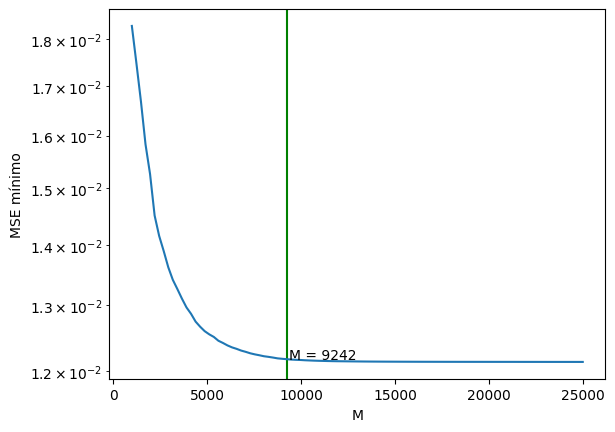

In [27]:
Ms = np.linspace(1000, 25000, 100, dtype=int)
jos = np.zeros(len(Ms))
found = False
last = 0

plt.figure()
for i, M in enumerate(Ms):
    wo, jo, nmse = hp.get_optimal_params(origSignal['chirpLin'], recSignal['chirpLin'], M)
    jos[i] = jo
    if i != 0 and last/jo-1 < 0.0005 and not found:
        plt.axvline(x=Ms[i], c='green')
        plt.text(x=Ms[i]+100, y=jo, s=f'M = {Ms[i]}')
        found = True
    last = jo

plt.xlabel('M')
plt.ylabel('MSE mínimo')
plt.semilogy(Ms, jos)

En el gráfico se puede ver marcado con una línea verde el valor del M óptimo.

# $\textit{4)}$

Obtenemos la estimación de h(n) para cada excitación.

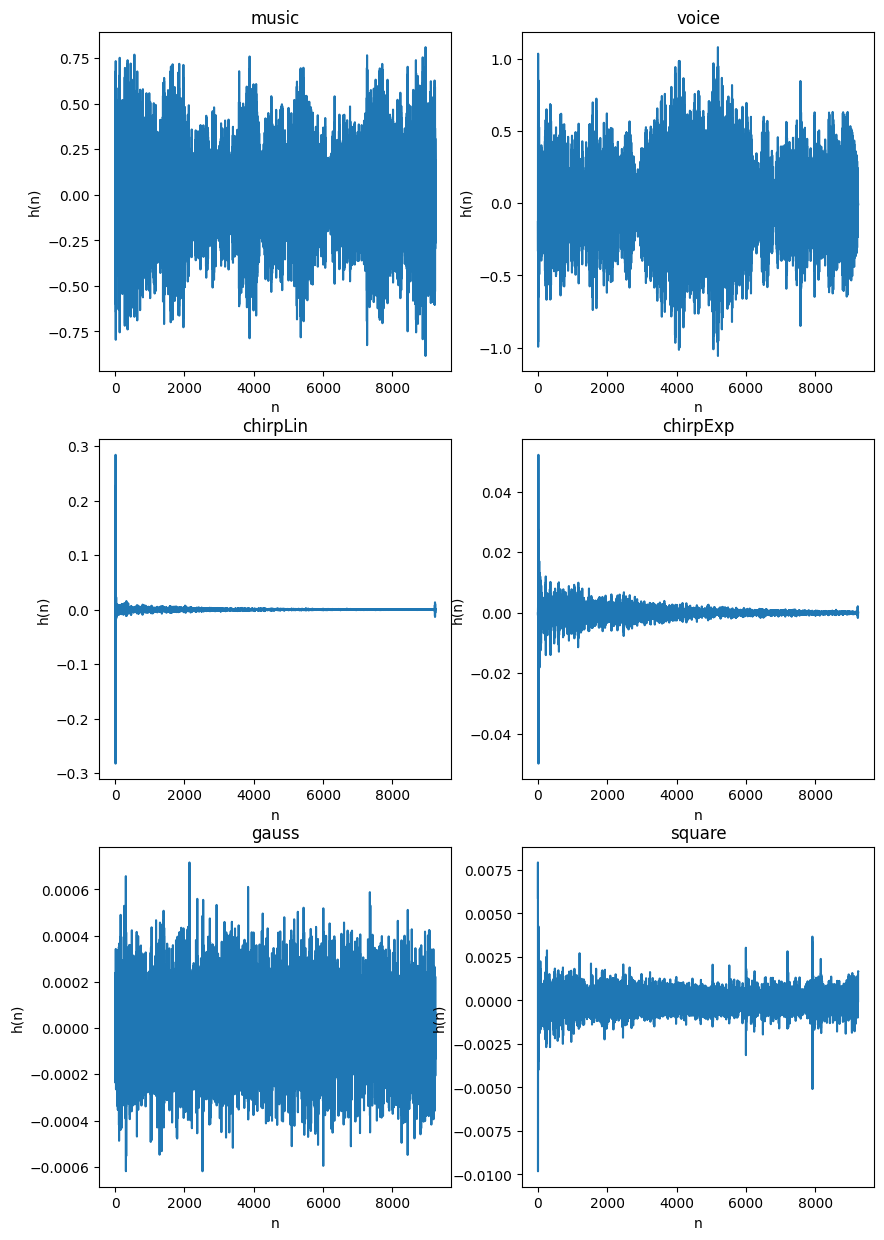

In [28]:
M = 9242 #Ordenes optimo encontrado
h_n = []
nmses = []
jos = []

plt.figure(figsize=(10, 15))
for i, (name, os, rs) in enumerate(zip(origSignal.keys(), origSignal.values(), recSignal.values())):
    h, jo, nmse = hp.get_optimal_params(os, rs, M)
    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('n')
    plt.ylabel('h(n)')
    plt.plot(h)
    h_n.append(h)
    nmses.append(nmse)
    jos.append(jo)

plt.show()

Obtenemos la respuesta en frecuencia de cada estimación de h(n).

In [30]:
plt.figure(figsize=(10, 15))
for i, (name, h) in enumerate(zip(recSignal.keys(), h_n)):
    paddingLen = hp.getNextPowerOfTwo(len(h)*20)
    H = np.fft.rfft(h, paddingLen)
    f = np.fft.rfftfreq(paddingLen, 1/fs)

    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('f')
    plt.ylabel('$|H(e^{j\omega})|_{db}$')
    plt.xlim([f0,f1])
    plt.semilogx(f, 20*np.log10(np.abs(H)/abs(H).max()))
plt.show()

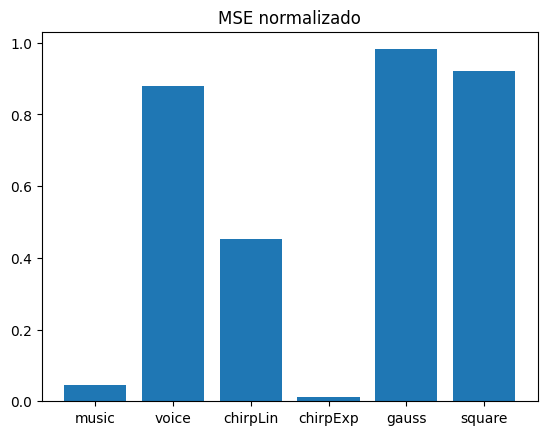

In [31]:
plt.figure()
plt.title("MSE normalizado")
plt.bar(recSignal.keys(), nmses)
plt.show()

Aclaración: Para obtener las transformadas de las respuestas impulsivas no se utilizó ninguna ventana, solo se tomaron los pesos y se calculó la DFT. Esto es posible ya que en un sistema con respuesta FIR, esta es nula antes de la excitación y luego de $n > (M-1)$, donde M es el orden del sistema. Si se desarrolla la DFT, se puede ver que es equivalente a la DTFT muestreada en cada punto k, es decir:

$
DTFT\{h\}(f)|_k = DFT\{h\}(k)
$

En un principio, a simple vista se puede ver que las respuestas impulsivas de ambos chirps resultan similares y resaltan en comparación con las demás. Analizando la respuesta en frecuencia, se puede ver en todas tienen un pico de ganancia alrededor de los 10kHz, es decir, que se resaltan los altos. Esto se puede oír en las grabaciones, donde los ruidos agudos se perciben más que los graves. Se cree que esto es debido a la respuesta del microfono del telefono celular utilizado, el cúal tiene un realzamiento en esas frecuencias para un mejora en la calidad de grabación de voz.

Cabe destacar el bajo MSE normalizado que tuvo la estimación con señal de música. Al observar el Jo, también resulto bajo en comparación a las demas señales, siendo este de $6,7e-4$, mientras que los demás se encontraban en el orden de $1e-3$ y $1e-2$ a excepción del Jo del barrido exponencial, siendo su $Jo = 1,4e-4$.

Otro resultado interesante en la señal musical es que su respuesta en frecuencia es muy similar a ambos barridos con una diferencia significativa en las frecuencias del orden de 20kHz, donde se ve un pico de ganancia que alcanza los 0dB. Debido a la frecuencia donde se encuentra el efecto, probablemente no sea perceptible al oído humano. 

En las señales de barrido, se puede observar un efecto pasa-altos en las bajas frecuencias, el cúal no se encuentra en las demás señales, lo cual probablemente se deba a que estas están generadas artificialmente con un ancho de banda fijo de 20Hz a 20kHz. De todas formas, lo mismo se podría decir de la señal cuadrada. Sin embargo, esta no presenta ese efecto. En los casos donde el MSE normalizado es alto, este efecto puede verse obstruido por el nivel de ruido en la estimación.

Otra observación interesante es que en las respuestas estimadas con los barridos de frecuencia, se puede ver un pequeño pico de amplitud al final de la respuesta temporal. No se pudo llegar a una conclusión sobre el motivo de la aparición de este fenómeno, pero se cree que puede deberse al efecto de la falta de excitación en el rango completo de frecuencias de 0Hz a 24KHz. Esto se manifiesta en el espectro como un rápido crecimiento en las bandas de frecuencia que no se excitaron.

# $\textit{5)}$

En la sección anterior se vió que la estimación por música resultó sobresaliente comparada a las demás, incluso mejor (en el sentido del MSE y el MSE normalizado) que la estimación debida al barrido lineal. Este último se creía que brindaría la mejor estimación, pero resultó ser la 3ra mejor estimación (en el sentido del MSE normalizado). Probablemente, este resultado se explique por el contenido espectral de la señal musical, que resulta rico en la banda del audio. De todos modos, se esperaba que el ruido de estimación fuera mayor que el resultante.

En particular, la mejor estimación (en el sentido de MSE y MSE normalizado) fué lograda por el barrido exponencial, lo cual no fué inesperado, ya que se anticipaba que los barridos con su respuesta en frecuencia poco ruidosa dieran una excitación limpia, obteniendo asi una buena estimación.



# $\textit{6)}$

En base a los gráficos presentados, a simple vista se pueden descartar las estimaciones dadas por la señal de voz, la señal cuadrada, y el ruido blanco gaussiano. Estas 3 son aquellas de mayor MSE normalizado y además, su respuesta impulsiva no tiene sentido físico para un cuarto donde es los ecos son de corta duración (como lo es el lugar donde se grabaron los audios).

Por otro lado, se tiene la señal de música, que a pesar de tener un MSE normalizado de aproximadamente 0.036, su respuesta impulsiva presenta el mismo problema que las anteriores, por lo que no la consideramos una buena estimación.

Por último, el chirp lineal y exponencial son los que presentan respuestas impulsivas acordes al modelo físico de ecos, con la distinción de que el chirp exponencial tiene ecos mucho más significativos y presentes en comparacion al lineal. Además, el barrido exponencial es el que presenta menor MSE normalizado, por lo que se lo considera la estimación más apropiada del sistema ensayado.

Utilizando esta respuesta estimada con el barrido exponencial se filtraron las distintas señales y se comparo con la grabación. La unica observación fué que los bajos se percibian con menos potencia que los agudos, incluso mas que en las grabaciones. Esto podria deberse a un exceso de amplificación en la banda de altas frecuencias.

In [32]:
# indice de h_n representa la respuesta a utilizar : 0: musica, 1: Voz, 2: barrido lineal, 3: barrido exponencial, 4: ruido blanco, 5: señal cuadrada 
result = sp.convolve(h_n[3], recSignal['music'], mode='full') / sum(recSignal['music'])

In [33]:
hp.play(recSignal["music"], recfs["music"])

In [34]:
hp.play(result, fs)